In [1]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.fit_model as fit_model

import itertools
import torch
import pandas as pd
import random
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"



class EPIS_dense(torch.nn.Module):
    def __init__(self, ISNet, psMatrices, populations, firstTS, device="cpu", train=False, cc=None, recursive=False):
        super(EPIS_dense, self).__init__()
        self._n= ISNet.size()[0]
        self._models= []
        self._numVirus= len(psMatrices)
        for i in range(self._numVirus):
            model= fit_model.EPI_dense( ISNet, psMatrices[i], populations[i], device, train=train, cc=cc, recursive=recursive, sampleAsState=True)
            self._models.append(model)
        self._firstTS= firstTS
        self._train= train
        self._t= 0
    def forward(self):
        self._t+=1
        exceptions= []
        statisticI= torch.zeros(self._n).to(device)
        probabilityWise= torch.ones(self._n).to(device)
        for i in range(self._numVirus):
            if self._firstTS[i]>self._t:
                expectation= self._models[i].get_population_num()
            else:
                expectation, _, prob = self._models[i].forward()
                probabilityWise*= (1-prob[2])
            state= self._models[i].get_population()
            statisticI= torch.logical_or(state[2, :], statisticI)
            exceptions.append(expectation)
        probability= 1-probabilityWise
        exceptions= torch.stack(exceptions)
        return exceptions, statisticI.sum(dim=0), probability.sum(dim=0)
    def parameters(self):
        parametersList=[]
        for i in range(self._numVirus):
            parametersList.append(self._models[i].parameters())
        return itertools.chain(*parametersList)
    def get_psMatrices(self):
        psMatrices= []
        for i in range(self._numVirus):
            psMatrices.append(self._models[i].get_psMatrix())
        return psMatrices
    def reset_populations(self, populations):
        for i in range(self._numVirus):
            self._models[i].reset_population(populations[i])

        

In [2]:
def sim(timeHorizon, model: EPIS_dense):
  populationNumbers= []
  populationExpectations= []
  statisticInfecteds=[]
  for i in range(timeHorizon):
    populationNumber, statisticI, populationExpectation= model()
    populationNumbers.append(populationNumber)
    populationExpectations.append(populationExpectation)
    statisticInfecteds.append(statisticI)

  populationNumbers = torch.stack(populationNumbers)
  populationExpectations = torch.stack(populationExpectations)
  statisticInfecteds = torch.stack(statisticInfecteds)

  return populationNumbers, populationExpectations, statisticInfecteds

In [4]:
n= 1000
avgDegree= 10
timeHorizon= 300
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
contact = contact.requires_grad_(True)
realData =None
with torch.no_grad():
    ps1= torch.tensor([[0, 0.04, 0, 0],
                      [0, 0, 0.5, 0],
                      [0, 0, 0, 0.15],
                      [0, 0, 0, 0]], device=device)
    ps2= torch.tensor([[0, 0.1, 0, 0],
                      [0, 0, 0.4, 0],
                      [0, 0, 0, 0.04],
                      [0, 0, 0, 0]], device=device)
    pss= [ps1,ps2]
    firstTs= [0, 80]
    populations= create_population.populations(n, 2, device)
    model= EPIS_dense(contact, pss, populations, firstTs, device)
    realData, expectation, statisticInfecteds =sim(timeHorizon, model)
    realData= realData.sum(dim=1)
    print(statisticInfecteds.shape)
    print(expectation.shape)


torch.Size([300])
torch.Size([300])


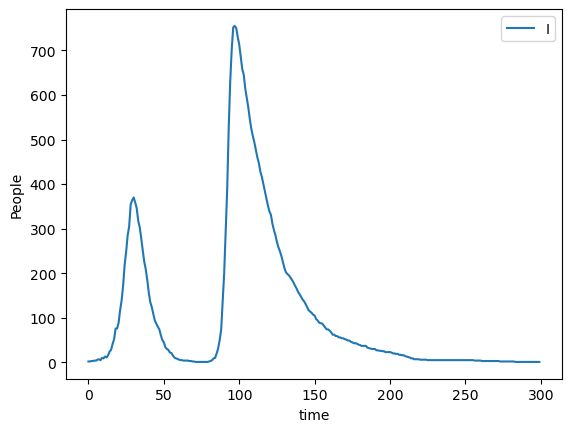

In [5]:
populationNumberPlot= realData.cpu().detach()
statisticInfectedsPlot= statisticInfecteds.cpu().detach()
expectationPlot= expectation.cpu().detach()
plt.plot(statisticInfectedsPlot, label='I')
#plt.plot(expectationPlot, label="E")
#plt.plot(populationNumberPlot[:, 2], label="I2")
plt.xlabel("time")
plt.ylabel("People")
plt.legend()

In [12]:
#realData.requires_grad_(True)
expectation.requires_grad_(True)
statisticInfecteds= statisticInfecteds.to(torch.float32)
statisticInfecteds.requires_grad_(True)
psFit1= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
psFit2= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
psFits=[psFit1, psFit2]
cc= torch.tensor([  [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [0, 0, 0, 0]], device=device)
populationsFit= create_population.populations(n, 2, device)
modelFit= EPIS_dense(contact, psFits, populationsFit, firstTs, device, train=True, cc=cc, recursive=True)
lossFn = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.Adam(modelFit.parameters(), lr=3e-1)

In [13]:
#fitPinfs=[]
#1. choose a better optimiser
#2. bigmodel learn intrinsic, gradient easy model !!!
#3. adaptive constraint?
#4. GAN ?
losses= []
for i in tqdm(range(500)):
    optimizer.zero_grad()
    #fitPinfs.append(modelFit.get_psMatrix())
    populationsFit= create_population.populations(n, 2, device)
    modelFit.reset_populations(populationsFit)
    _ , expectationFit, _ = sim(timeHorizon, modelFit)
    #loss= lossFn(expectation, realData)/n/timeHorizon
    loss= lossFn(expectationFit, expectation)/n/timeHorizon
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
print(modelFit.get_psMatrices())

  1%|          | 5/500 [00:06<11:07,  1.35s/it]


KeyboardInterrupt: 

[tensor([[0.0000, 0.8156, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0200, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8215],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>), tensor([[0.0000, 0.8272, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0216, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4526],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)]


Text(0, 0.5, 'loss')

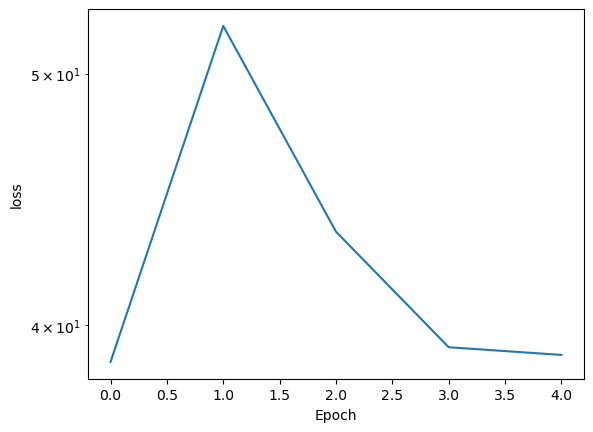

In [14]:
print(modelFit.get_psMatrices())
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("loss")

In [15]:
def print_model_parameters(models):
    for model in models._models:
        for name, parameter in model.named_parameters():
            print('name           : {}'.format(name))
            print('parameter      : {}'.format(parameter))
            print('learnable      : {}'.format(parameter.requires_grad))
            print('parameter.shape: {}'.format(parameter.shape))
            print('parameter.grad: {}'.format(parameter.grad))
            print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[-1.2927,  1.2927, -1.2927, -1.2927],
        [ 1.3976,  1.3976, -1.3976,  1.3976],
        [-1.3126, -1.3126, -1.3126,  1.3126],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], device='cuda:0')
---------------------------------
name           : _psMatrix
parameter      : Parameter containing:
tensor([[-1.3323,  1.3323, -1.3323, -1.3323],
        [ 1.3582,  1.3582, -1.3582,  1.3582],
        [-0.4542, -0.4542, -0.4542,  0.4542],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], d

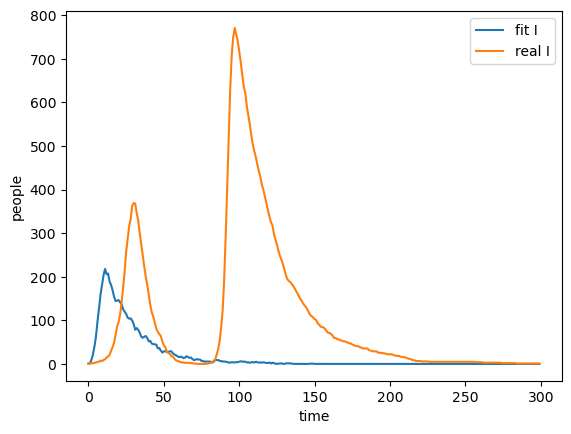

In [17]:
expectationFitPlot= expectationFit.cpu().detach()
plt.plot(expectationFitPlot, label='fit I')
plt.plot(expectationPlot, label="real I")
plt.xlabel("time")
plt.ylabel("people")
plt.legend()